This training run is done on the new dataset with 1830 airfoils, 1 mach #, 25 AoA #s, and 3 Re #s.

It runs on a very deep MLP. The file without any _x numbers runs on ~16m params, while this one runs on ~24m params, this is just an exploratory analysis. For context, the widely used PairNIF before uses ~22m params. And NeuralFoil xxxlarge uses ~1m.

In [1]:
%load_ext autoreload
%autoreload 2

# Define autroreload so that it doesn't cause pain in the ass when we change the functions and run this notebook

In [2]:
# Import all the models, training functions, manipulators here

# Define the relative paths, append it to the system path
import sys
from pathlib import Path
project_root = Path.cwd().resolve().parents[3]
github_root = Path.cwd().resolve().parents[2]
sys.path.append(str(project_root))
sys.path.append(str(github_root))

print(project_root)
print(github_root)

# Import shenanigans
from defs.helper_functions.training_functions import *
from defs.helper_functions.data_loaders import *
from defs.models.MLP import *

# Time, to precisely: time
import time

C:\SenkDosya\Projects\AeroML
C:\SenkDosya\Projects\AeroML\initial-project


In [3]:
# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")  # Force CPU for testing purposes
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Figure out the data
df = pd.read_csv(rf"{str(project_root)}\airfoil_data\airfoil_dataset_8bern.csv")

df = df.drop(['N1', 'N2'], axis=1) # Remove N1 and N2 since all the airfoils are subsonic

df['Reynolds'] = df['Reynolds'] / 1000000 # Normalize the Reynolds feature, too dominant

print(df.head)

geom, cond, perf, names= get_dataset(df, loc_geometry=[1,20], loc_cond=[21,23], loc_perf_coeffs=[24,26], loc_names=0) # Get the necessary stuff for the dataset
print(df.shape); print(geom.shape); print(cond.shape); print(perf.shape); print(len(names))

ds = AirfoilDataset(geom, cond, perf, names)

del df, geom, cond, perf, names # Delete these to preserve memory

cfg_loader = {
    'n_epoch': 100,
    'n_train': 1000,
    'n_test': 17250,
    'train_batch': 1
}

dl_train, dl_val, dl_test = get_dataloaders(ds=ds, cfg_loader=cfg_loader)


<bound method NDFrame.head of         airfoil_name      Bu_0      Bu_1      Bu_2      Bu_3      Bu_4  \
0       airfoil_0001  0.273636 -0.200785  1.229138 -1.445725  1.790261   
1       airfoil_0001  0.273636 -0.200785  1.229138 -1.445725  1.790261   
2       airfoil_0001  0.273636 -0.200785  1.229138 -1.445725  1.790261   
3       airfoil_0001  0.273636 -0.200785  1.229138 -1.445725  1.790261   
4       airfoil_0001  0.273636 -0.200785  1.229138 -1.445725  1.790261   
...              ...       ...       ...       ...       ...       ...   
137245  airfoil_1830  0.327410  1.499799 -0.780311  3.149627 -1.415475   
137246  airfoil_1830  0.327410  1.499799 -0.780311  3.149627 -1.415475   
137247  airfoil_1830  0.327410  1.499799 -0.780311  3.149627 -1.415475   
137248  airfoil_1830  0.327410  1.499799 -0.780311  3.149627 -1.415475   
137249  airfoil_1830  0.327410  1.499799 -0.780311  3.149627 -1.415475   

            Bu_5      Bu_6      Bu_7     Bu_8  ...      Bl_7      Bl_8  \
0      

In [5]:
import torch.nn as nn

# Define the model and optimizer

cfg_mlp = {
    'input_dim': 23,
    'output_dim': 3,
    'hidden_units': [2048,2048,2048,2048,2048,2048,2048],
    'shape_activation': nn.Tanh
}

model = MLP(cfg_mlp=cfg_mlp)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

model = model.to(device)

# Define the loss_fn

loss_fn = nn.MSELoss()

In [6]:
# Show the model

from torchviz import make_dot

# Create and move inputs to device
show_tensor_1 = torch.randn(5, 20).to(device)
show_tensor_2 = torch.randn(5, 3).to(device)

# Forward pass
output = model(show_tensor_1, show_tensor_2)

make_dot(output, params=dict(model.named_parameters())).render("model_graph_mlp_2", format="png")

from defs.helper_functions.auxiliary import *



print(f'MLP Model Parameters: {get_n_params(model=model)}')

from defs.models.NIF import *

cfg_shape_net = {
    'input_dim': 20,
    'output_dim': 3,
    'hidden_units': [2048,2048,2048,2048,2048],
    'shape_activation': nn.SELU
}

cfg_param_net = {
    'input_dim': 3,
    'hidden_units': [512,512,512],
    'param_activation': nn.Tanh
}

model_NIF = NIF_Pointwise(cfg_shape_net=cfg_shape_net, cfg_param_net=cfg_param_net)

print(f'For Reference, PairNIF Model Parameters: {get_n_params(model=model_NIF)}')

MLP Model Parameters: 25233411
For Reference, PairNIF Model Parameters: 22616582


In [7]:
# Train the model

# Define the configs of train
cfg_train = {
    'cfg_loader': cfg_loader,
    'dtype': torch.float32,
    'device': device
}

dataloaders = [dl_train, dl_val, dl_test]


collector_dict, model = train(cfg_train=cfg_train, model=model, optimizer=optimizer, loss_fn=loss_fn, dataloaders=dataloaders)

Epoch 1 | Train run 1 loss: 0.9328986406326294
Epoch 1 | Train run 2 loss: 0.4068739414215088
Epoch 1 | Train run 3 loss: 0.2225666344165802
Epoch 1 | Train run 4 loss: 0.019404709339141846
Epoch 1 | Train run 5 loss: 0.03631606325507164
Epoch 1 | Train run 6 loss: 0.129530668258667
Epoch 1 | Train run 7 loss: 0.5624984502792358
Epoch 1 | Train run 8 loss: 0.016888491809368134
Epoch 1 | Train run 9 loss: 0.28779545426368713
Epoch 1 | Train run 10 loss: 0.12417082488536835
Epoch 1 | Train run 11 loss: 0.3991793990135193
Epoch 1 | Train run 12 loss: 0.020338689908385277
Epoch 1 | Train run 13 loss: 0.239776611328125
Epoch 1 | Train run 14 loss: 0.02229056879878044
Epoch 1 | Train run 15 loss: 0.038120366632938385
Epoch 1 | Train run 16 loss: 0.33792659640312195
Epoch 1 | Train run 17 loss: 0.0952906608581543
Epoch 1 | Train run 18 loss: 0.27926650643348694
Epoch 1 | Train run 19 loss: 0.011354230344295502
Epoch 1 | Train run 20 loss: 0.019584424793720245
Epoch 1 | Train run 21 loss: 0.21

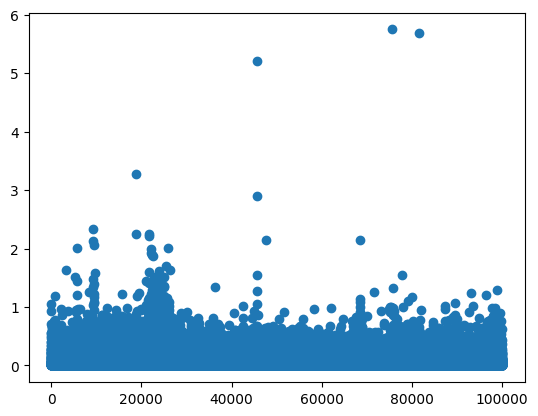

In [8]:
import numpy as np


train_losses = collector_dict['losses']['train'].numpy()
index= np.arange(100000)

import matplotlib.pyplot as plt

plt.scatter(index, train_losses, )
plt.show()

[0.18174948 0.10792852 0.06220953 0.06691504 0.03858288 0.10402934
 0.0938011  0.08878756 0.08147207 0.06961747 0.09499481 0.08319811
 0.07684104 0.11264637 0.09226439 0.06581783 0.08422383 0.08978242
 0.15000224 0.0796155  0.12098954 0.144188   0.17801988 0.10343216
 0.20511152 0.10774239 0.11812618 0.1033496  0.07241758 0.08754434
 0.07225951 0.072045   0.07815368 0.0945212  0.0871318  0.06563623
 0.09753461 0.10533738 0.08430085 0.07085973 0.05323327 0.09144065
 0.06884133 0.10501563 0.06853169 0.06189041 0.07367939 0.05995891
 0.05119583 0.06872706 0.07215712 0.06859311 0.05641548 0.04078239
 0.07549025 0.03944341 0.03421755 0.06421734 0.04832565 0.05303956
 0.04361949 0.06494372 0.06045223 0.12190297 0.08325033 0.05657349
 0.05634761 0.07876815 0.15589274 0.04937547 0.04405526 0.06553734
 0.04386785 0.07410555 0.05955637 0.09287246 0.04646807 0.06170099
 0.2106183  0.05506995 0.0750398  0.04328957 0.04037297 0.03970037
 0.04418729 0.04107329 0.03913977 0.04904932 0.04040631 0.1027

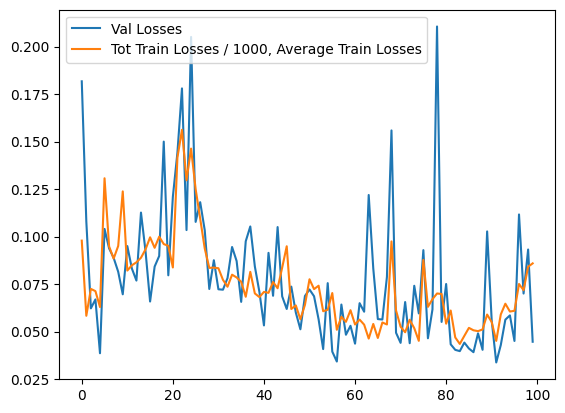

In [9]:
tot_train_losses = collector_dict['losses']['total_train'].numpy()/1000
val_losses = collector_dict['losses']['val'].numpy()

print(val_losses)
index = np.arange(100)

plt.plot(index, val_losses, label='Val Losses')
plt.plot(index, tot_train_losses, label= 'Tot Train Losses / 1000, Average Train Losses')
plt.legend()
plt.show()


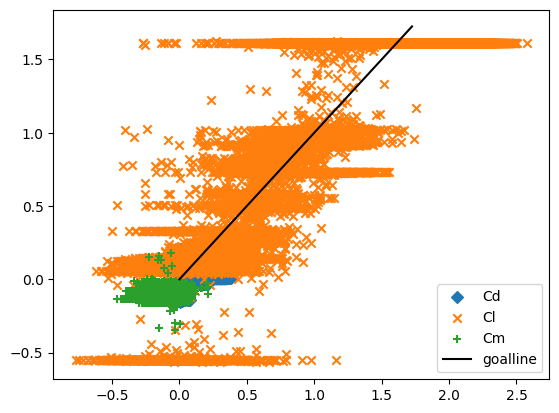

In [10]:
plt.scatter(collector_dict['actual']['test'][:,0].cpu().numpy(), collector_dict['preds']['test'][:,0].cpu().numpy(), marker='D', label= 'Cd')
plt.scatter(collector_dict['actual']['test'][:,1].cpu().numpy(), collector_dict['preds']['test'][:,1].cpu().numpy(), marker='x', label= 'Cl')
plt.scatter(collector_dict['actual']['test'][:,2].cpu().numpy(), collector_dict['preds']['test'][:,2].cpu().numpy(), marker='+', label= 'Cm')
plt.plot(np.arange(17250)/10000, np.arange(17250)/10000, color='k', label='goalline')
plt.legend()
plt.show()


From this training, one can make the following conclusions:

- 24m MLP definitely overfits

